# Curiosity-Driven Exploration

In [1]:
import gym

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim

In [3]:
import collections

In [4]:
env = gym.make('CartPole-v1')

In [5]:
class Actor(nn.Module):
    def __init__(self, n_actions, space_dims, hidden_dims):
        super(Actor, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dims, hidden_dims),
            nn.ReLU(True),
        )
        self.actor = nn.Sequential(
            nn.Linear(hidden_dims, n_actions),
            nn.Softmax(dim=-1),
        )
    
    def forward(self, x):
        features = self.feature_extractor(x)
        policy = self.actor(features)
        return policy
    
class Critic(nn.Module):
    def __init__(self, space_dims, hidden_dims):
        super(Critic, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Linear(space_dims, hidden_dims),
            nn.ReLU(True),
        )
        self.critic = nn.Linear(hidden_dims, 1)
    
    def forward(self, x):
        features = self.feature_extractor(x)
        est_reward = self.critic(features)
        return est_reward

In [6]:
class InverseModel(nn.Module):
    def __init__(self, n_actions, hidden_dims):
        super(InverseModel, self).__init__()
        self.fc = nn.Linear(hidden_dims*2, n_actions)
        
    def forward(self, features):
        features = features.view(1, -1) # (1, hidden_dims)
        action = self.fc(features) # (1, n_actions)
        return action

class ForwardModel(nn.Module):
    def __init__(self, n_actions, hidden_dims):
        super(ForwardModel, self).__init__()
        self.fc = nn.Linear(hidden_dims+n_actions, hidden_dims)
        self.eye = torch.eye(n_actions)
        
    def forward(self, action, features):
        x = torch.cat([self.eye[action], features], dim=-1) # (1, n_actions+hidden_dims)
        features = self.fc(x) # (1, hidden_dims)
        return features

class FeatureExtractor(nn.Module):
    def __init__(self, space_dims, hidden_dims):
        super(FeatureExtractor, self).__init__()
        self.fc = nn.Linear(space_dims, hidden_dims)
        
    def forward(self, x):
        y = torch.tanh(self.fc(x))
        return y

In [7]:
class PGLoss(nn.Module):
    def __init__(self):
        super(PGLoss, self).__init__()
    
    def forward(self, action_prob, reward):
        loss = -torch.mean(torch.log(action_prob+1e-6)*reward)
        return loss

In [8]:
def select_action(policy):
    return np.random.choice(len(policy), 1, p=policy)[0]

In [9]:
def to_tensor(x, dtype=None):
    return torch.tensor(x, dtype=dtype).unsqueeze(0)

In [10]:
class ConfigArgs:
    beta = 0.2
    lamda = 0.1
    eta = 100.0 # scale factor for intrinsic reward
    discounted_factor = 0.99
    lr_critic = 0.005
    lr_actor = 0.001
    lr_icm = 0.001
    max_eps = 1000
    sparse_mode = True

args = ConfigArgs()

In [11]:
# Actor Critic
actor = Actor(n_actions=env.action_space.n, space_dims=4, hidden_dims=32)
critic = Critic(space_dims=4, hidden_dims=32)

In [12]:
# ICM
feature_extractor = FeatureExtractor(env.observation_space.shape[0], 32)
forward_model = ForwardModel(env.action_space.n, 32)
inverse_model = InverseModel(env.action_space.n, 32)

In [13]:
# Actor Critic
a_optim = torch.optim.Adam(actor.parameters(), lr=args.lr_actor)
c_optim = torch.optim.Adam(critic.parameters(), lr=args.lr_critic)

# ICM
icm_params = list(feature_extractor.parameters()) + list(forward_model.parameters()) + list(inverse_model.parameters())
icm_optim = torch.optim.Adam(icm_params, lr=args.lr_icm)

In [14]:
pg_loss = PGLoss()
mse_loss = nn.MSELoss()
xe_loss = nn.CrossEntropyLoss()

In [15]:
global_step = 0
n_eps = 0
reward_lst = []
mva_lst = []
mva = 0.
avg_ireward_lst = []

while n_eps < args.max_eps:
    n_eps += 1
    next_obs = to_tensor(env.reset(), dtype=torch.float)
    done = False
    score = 0
    ireward_lst = []
    
    while not done:
        obs = next_obs
        a_optim.zero_grad()
        c_optim.zero_grad()
        icm_optim.zero_grad()
        
        # estimate action with policy network
        policy = actor(obs)
        action = select_action(policy.detach().numpy()[0])
        
        # interaction with environment
        next_obs, reward, done, info = env.step(action)
        next_obs = to_tensor(next_obs, dtype=torch.float)
        advantages = torch.zeros_like(policy)
        extrinsic_reward = to_tensor([0.], dtype=torch.float) if args.sparse_mode else to_tensor([reward], dtype=torch.float)
        t_action = to_tensor(action)
        
        v = critic(obs)[0]
        next_v = critic(next_obs)[0]
        
        # ICM
        obs_cat = torch.cat([obs, next_obs], dim=0)
        features = feature_extractor(obs_cat) # (2, hidden_dims)
        inverse_action_prob = inverse_model(features) # (n_actions)
        est_next_features = forward_model(t_action, features[0:1])

        # Loss - ICM
        forward_loss = mse_loss(est_next_features, features[1])
        inverse_loss = xe_loss(inverse_action_prob, t_action.view(-1))
        icm_loss = (1-args.beta)*inverse_loss + args.beta*forward_loss
        
        # Reward
        intrinsic_reward = args.eta*forward_loss.detach()
        if done:
            total_reward = -100 + intrinsic_reward if score < 499 else intrinsic_reward
            advantages[0, action] = total_reward - v
            c_target = total_reward
        else:
            total_reward = extrinsic_reward + intrinsic_reward
            advantages[0, action] = total_reward + args.discounted_factor*next_v - v
            c_target = total_reward + args.discounted_factor*next_v
        
        # Loss - Actor Critic
        actor_loss = pg_loss(policy, advantages.detach())
        critic_loss = mse_loss(v, c_target.detach())
        ac_loss = actor_loss + critic_loss
        
        # Update
        loss = args.lamda*ac_loss + icm_loss
        loss.backward()
        icm_optim.step()
        a_optim.step()
        c_optim.step()
        
        if not done:
            score += reward
        
        ireward_lst.append(intrinsic_reward.item())
        
        global_step += 1
    avg_intrinsic_reward = sum(ireward_lst) / len(ireward_lst)
    mva = 0.95*mva + 0.05*score
    reward_lst.append(score)
    avg_ireward_lst.append(avg_intrinsic_reward)
    mva_lst.append(mva)
    print('Episodes: {}, AVG Score: {:.3f}, Score: {}, AVG reward i: {:.6f}'.format(n_eps, mva, score, avg_intrinsic_reward))

Episodes: 1, AVG Score: 1.350, Score: 27.0, AVG intrinsic reward: 11.123327
Episodes: 2, AVG Score: 1.883, Score: 12.0, AVG intrinsic reward: 8.384964
Episodes: 3, AVG Score: 2.438, Score: 13.0, AVG intrinsic reward: 2.913019
Episodes: 4, AVG Score: 3.716, Score: 28.0, AVG intrinsic reward: 2.982554
Episodes: 5, AVG Score: 4.281, Score: 15.0, AVG intrinsic reward: 1.379303
Episodes: 6, AVG Score: 5.567, Score: 30.0, AVG intrinsic reward: 1.400859
Episodes: 7, AVG Score: 7.288, Score: 40.0, AVG intrinsic reward: 1.311737
Episodes: 8, AVG Score: 7.474, Score: 11.0, AVG intrinsic reward: 1.412290
Episodes: 9, AVG Score: 7.950, Score: 17.0, AVG intrinsic reward: 0.792913
Episodes: 10, AVG Score: 8.003, Score: 9.0, AVG intrinsic reward: 0.782326
Episodes: 11, AVG Score: 8.753, Score: 23.0, AVG intrinsic reward: 1.288839
Episodes: 12, AVG Score: 9.265, Score: 19.0, AVG intrinsic reward: 0.664575
Episodes: 13, AVG Score: 10.252, Score: 29.0, AVG intrinsic reward: 0.745696
Episodes: 14, AVG Sc

Episodes: 109, AVG Score: 38.187, Score: 84.0, AVG intrinsic reward: 0.204245
Episodes: 110, AVG Score: 38.328, Score: 41.0, AVG intrinsic reward: 0.249264
Episodes: 111, AVG Score: 38.362, Score: 39.0, AVG intrinsic reward: 0.158791
Episodes: 112, AVG Score: 39.044, Score: 52.0, AVG intrinsic reward: 0.137983
Episodes: 113, AVG Score: 41.091, Score: 80.0, AVG intrinsic reward: 0.190762
Episodes: 114, AVG Score: 41.987, Score: 59.0, AVG intrinsic reward: 0.334328
Episodes: 115, AVG Score: 42.338, Score: 49.0, AVG intrinsic reward: 0.307754
Episodes: 116, AVG Score: 45.271, Score: 101.0, AVG intrinsic reward: 0.345914
Episodes: 117, AVG Score: 46.307, Score: 66.0, AVG intrinsic reward: 0.225329
Episodes: 118, AVG Score: 46.342, Score: 47.0, AVG intrinsic reward: 0.347012
Episodes: 119, AVG Score: 45.675, Score: 33.0, AVG intrinsic reward: 0.284150
Episodes: 120, AVG Score: 45.741, Score: 47.0, AVG intrinsic reward: 0.237797
Episodes: 121, AVG Score: 47.704, Score: 85.0, AVG intrinsic re

Episodes: 214, AVG Score: 70.555, Score: 42.0, AVG intrinsic reward: 0.116316
Episodes: 215, AVG Score: 69.928, Score: 58.0, AVG intrinsic reward: 0.294648
Episodes: 216, AVG Score: 68.231, Score: 36.0, AVG intrinsic reward: 0.236755
Episodes: 217, AVG Score: 67.820, Score: 60.0, AVG intrinsic reward: 0.294116
Episodes: 218, AVG Score: 66.779, Score: 47.0, AVG intrinsic reward: 0.130523
Episodes: 219, AVG Score: 65.890, Score: 49.0, AVG intrinsic reward: 0.237548
Episodes: 220, AVG Score: 64.845, Score: 45.0, AVG intrinsic reward: 0.193177
Episodes: 221, AVG Score: 63.753, Score: 43.0, AVG intrinsic reward: 0.139511
Episodes: 222, AVG Score: 62.715, Score: 43.0, AVG intrinsic reward: 0.206082
Episodes: 223, AVG Score: 62.630, Score: 61.0, AVG intrinsic reward: 0.318015
Episodes: 224, AVG Score: 61.598, Score: 42.0, AVG intrinsic reward: 0.098158
Episodes: 225, AVG Score: 61.218, Score: 54.0, AVG intrinsic reward: 0.115393
Episodes: 226, AVG Score: 69.257, Score: 222.0, AVG intrinsic re

Episodes: 318, AVG Score: 163.912, Score: 173.0, AVG intrinsic reward: 0.039095
Episodes: 319, AVG Score: 161.567, Score: 117.0, AVG intrinsic reward: 0.081321
Episodes: 320, AVG Score: 158.838, Score: 107.0, AVG intrinsic reward: 0.075940
Episodes: 321, AVG Score: 156.946, Score: 121.0, AVG intrinsic reward: 0.089418
Episodes: 322, AVG Score: 153.399, Score: 86.0, AVG intrinsic reward: 0.044426
Episodes: 323, AVG Score: 150.179, Score: 89.0, AVG intrinsic reward: 0.062204
Episodes: 324, AVG Score: 149.970, Score: 146.0, AVG intrinsic reward: 0.017997
Episodes: 325, AVG Score: 149.172, Score: 134.0, AVG intrinsic reward: 0.022244
Episodes: 326, AVG Score: 149.563, Score: 157.0, AVG intrinsic reward: 0.035605
Episodes: 327, AVG Score: 145.985, Score: 78.0, AVG intrinsic reward: 0.027488
Episodes: 328, AVG Score: 143.786, Score: 102.0, AVG intrinsic reward: 0.032885
Episodes: 329, AVG Score: 141.396, Score: 96.0, AVG intrinsic reward: 0.027156
Episodes: 330, AVG Score: 139.277, Score: 99

Episodes: 423, AVG Score: 84.717, Score: 254.0, AVG intrinsic reward: 0.012260
Episodes: 424, AVG Score: 85.081, Score: 92.0, AVG intrinsic reward: 0.014911
Episodes: 425, AVG Score: 91.877, Score: 221.0, AVG intrinsic reward: 0.007953
Episodes: 426, AVG Score: 91.033, Score: 75.0, AVG intrinsic reward: 0.010356
Episodes: 427, AVG Score: 91.831, Score: 107.0, AVG intrinsic reward: 0.006683
Episodes: 428, AVG Score: 90.790, Score: 71.0, AVG intrinsic reward: 0.008596
Episodes: 429, AVG Score: 92.300, Score: 121.0, AVG intrinsic reward: 0.014562
Episodes: 430, AVG Score: 97.885, Score: 204.0, AVG intrinsic reward: 0.010246
Episodes: 431, AVG Score: 104.441, Score: 229.0, AVG intrinsic reward: 0.012569
Episodes: 432, AVG Score: 110.069, Score: 217.0, AVG intrinsic reward: 0.007736
Episodes: 433, AVG Score: 109.265, Score: 94.0, AVG intrinsic reward: 0.008828
Episodes: 434, AVG Score: 114.602, Score: 216.0, AVG intrinsic reward: 0.007313
Episodes: 435, AVG Score: 113.022, Score: 83.0, AVG 

Episodes: 528, AVG Score: 70.522, Score: 78.0, AVG intrinsic reward: 0.030873
Episodes: 529, AVG Score: 69.896, Score: 58.0, AVG intrinsic reward: 0.006658
Episodes: 530, AVG Score: 70.801, Score: 88.0, AVG intrinsic reward: 0.005892
Episodes: 531, AVG Score: 73.661, Score: 128.0, AVG intrinsic reward: 0.036003
Episodes: 532, AVG Score: 73.128, Score: 63.0, AVG intrinsic reward: 0.021835
Episodes: 533, AVG Score: 71.922, Score: 49.0, AVG intrinsic reward: 0.007029
Episodes: 534, AVG Score: 71.476, Score: 63.0, AVG intrinsic reward: 0.004345
Episodes: 535, AVG Score: 72.002, Score: 82.0, AVG intrinsic reward: 0.008979
Episodes: 536, AVG Score: 72.552, Score: 83.0, AVG intrinsic reward: 0.008138
Episodes: 537, AVG Score: 72.874, Score: 79.0, AVG intrinsic reward: 0.009660
Episodes: 538, AVG Score: 72.330, Score: 62.0, AVG intrinsic reward: 0.010625
Episodes: 539, AVG Score: 71.514, Score: 56.0, AVG intrinsic reward: 0.007438
Episodes: 540, AVG Score: 70.988, Score: 61.0, AVG intrinsic re

Episodes: 632, AVG Score: 474.858, Score: 499.0, AVG intrinsic reward: 0.000706
Episodes: 633, AVG Score: 476.065, Score: 499.0, AVG intrinsic reward: 0.000440
Episodes: 634, AVG Score: 477.212, Score: 499.0, AVG intrinsic reward: 0.000685
Episodes: 635, AVG Score: 478.301, Score: 499.0, AVG intrinsic reward: 0.000952
Episodes: 636, AVG Score: 479.336, Score: 499.0, AVG intrinsic reward: 0.000376
Episodes: 637, AVG Score: 480.319, Score: 499.0, AVG intrinsic reward: 0.001454
Episodes: 638, AVG Score: 480.353, Score: 481.0, AVG intrinsic reward: 0.002852
Episodes: 639, AVG Score: 470.936, Score: 292.0, AVG intrinsic reward: 0.001437
Episodes: 640, AVG Score: 457.739, Score: 207.0, AVG intrinsic reward: 0.002316
Episodes: 641, AVG Score: 446.352, Score: 230.0, AVG intrinsic reward: 0.000734
Episodes: 642, AVG Score: 432.734, Score: 174.0, AVG intrinsic reward: 0.000991
Episodes: 643, AVG Score: 420.248, Score: 183.0, AVG intrinsic reward: 0.001803
Episodes: 644, AVG Score: 409.435, Score

Episodes: 736, AVG Score: 305.523, Score: 57.0, AVG intrinsic reward: 0.006507
Episodes: 737, AVG Score: 315.197, Score: 499.0, AVG intrinsic reward: 0.002749
Episodes: 738, AVG Score: 324.387, Score: 499.0, AVG intrinsic reward: 0.001371
Episodes: 739, AVG Score: 315.868, Score: 154.0, AVG intrinsic reward: 0.003509
Episodes: 740, AVG Score: 300.575, Score: 10.0, AVG intrinsic reward: 0.011394
Episodes: 741, AVG Score: 310.496, Score: 499.0, AVG intrinsic reward: 0.000372
Episodes: 742, AVG Score: 319.921, Score: 499.0, AVG intrinsic reward: 0.000037
Episodes: 743, AVG Score: 328.875, Score: 499.0, AVG intrinsic reward: 0.000528
Episodes: 744, AVG Score: 337.381, Score: 499.0, AVG intrinsic reward: 0.000388
Episodes: 745, AVG Score: 345.462, Score: 499.0, AVG intrinsic reward: 0.000206
Episodes: 746, AVG Score: 353.139, Score: 499.0, AVG intrinsic reward: 0.000431
Episodes: 747, AVG Score: 360.432, Score: 499.0, AVG intrinsic reward: 0.000377
Episodes: 748, AVG Score: 367.361, Score: 

Episodes: 839, AVG Score: 497.763, Score: 499.0, AVG intrinsic reward: 0.000078
Episodes: 840, AVG Score: 497.825, Score: 499.0, AVG intrinsic reward: 0.000061
Episodes: 841, AVG Score: 497.884, Score: 499.0, AVG intrinsic reward: 0.000322
Episodes: 842, AVG Score: 497.940, Score: 499.0, AVG intrinsic reward: 0.000065
Episodes: 843, AVG Score: 497.993, Score: 499.0, AVG intrinsic reward: 0.000105
Episodes: 844, AVG Score: 498.043, Score: 499.0, AVG intrinsic reward: 0.000410
Episodes: 845, AVG Score: 498.091, Score: 499.0, AVG intrinsic reward: 0.000013
Episodes: 846, AVG Score: 498.136, Score: 499.0, AVG intrinsic reward: 0.000028
Episodes: 847, AVG Score: 498.180, Score: 499.0, AVG intrinsic reward: 0.000042
Episodes: 848, AVG Score: 498.221, Score: 499.0, AVG intrinsic reward: 0.000150
Episodes: 849, AVG Score: 498.260, Score: 499.0, AVG intrinsic reward: 0.000193
Episodes: 850, AVG Score: 498.297, Score: 499.0, AVG intrinsic reward: 0.000536
Episodes: 851, AVG Score: 498.332, Score

Episodes: 942, AVG Score: 406.249, Score: 105.0, AVG intrinsic reward: 0.024884
Episodes: 943, AVG Score: 386.637, Score: 14.0, AVG intrinsic reward: 0.091638
Episodes: 944, AVG Score: 367.805, Score: 10.0, AVG intrinsic reward: 0.202953
Episodes: 945, AVG Score: 359.915, Score: 210.0, AVG intrinsic reward: 0.038101
Episodes: 946, AVG Score: 352.769, Score: 217.0, AVG intrinsic reward: 0.007289
Episodes: 947, AVG Score: 344.080, Score: 179.0, AVG intrinsic reward: 0.014950
Episodes: 948, AVG Score: 333.476, Score: 132.0, AVG intrinsic reward: 0.013527
Episodes: 949, AVG Score: 324.703, Score: 158.0, AVG intrinsic reward: 0.014355
Episodes: 950, AVG Score: 316.517, Score: 161.0, AVG intrinsic reward: 0.008304
Episodes: 951, AVG Score: 308.692, Score: 160.0, AVG intrinsic reward: 0.007466
Episodes: 952, AVG Score: 301.057, Score: 156.0, AVG intrinsic reward: 0.008680
Episodes: 953, AVG Score: 294.104, Score: 162.0, AVG intrinsic reward: 0.009982
Episodes: 954, AVG Score: 286.849, Score: 

## Visualization

In [16]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

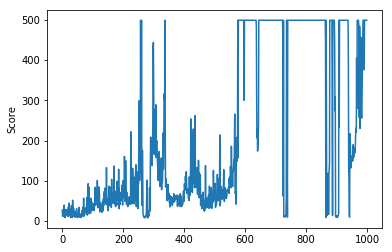

In [17]:
plt.plot(reward_lst)
plt.ylabel('Score')
plt.show()

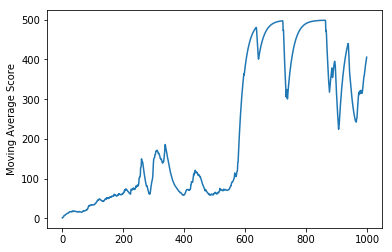

In [18]:
plt.plot(mva_lst)
plt.ylabel('Moving Average Score')
plt.show()

In [19]:
np.save('curiosity-mva.npy', np.array(mva_lst))